In [1]:
import time
import arviz
import numpy as np
import pandas as pd
import pystan


In [2]:
# Parameters
P = 10
N = 10 ** 4
N_resample = 3*(10 ** 4)
SEED = 1729

In [3]:
# Ground truth
np.random.seed(SEED)
true_transmission_rate = np.random.beta(2, 10, P)
true_occurrence_rate = np.random.beta(2, 10, P)
base_rate = np.random.beta(2, 10, 1)


In [4]:
# Simulate data
data = {}
for p in range(P):
    occurrence = np.random.binomial(1, true_occurrence_rate[p], N)
    transmission = occurrence * np.random.binomial(1, true_transmission_rate[p], N)
    data[f'O{p+1}'] = occurrence
    data[f'T{p+1}'] = transmission
    
data['T0'] = np.random.binomial(1, base_rate, N)
X = pd.DataFrame(data)
z = X.loc[:, X.columns.str.startswith('T')].sum(axis=1)
y = (z > 0).astype(int)
X = X.loc[:, X.columns.str.startswith('O')]

X.info()

In [5]:
# Create model
sm = pystan.StanModel(model_name='tt_mod', model_code="""
data {
  int<lower=0> N;                            // number of observations
  int<lower=0> P;                            // number of places
  int<lower=0, upper=1> X[N,P];              // activity occurrences
  int<lower=0, upper=1> y[N];                // transmission (tested positive)
}
parameters {
  real<lower=0, upper=1> theta[P];           // transmission rates
  real<lower=0, upper=1> rho;                // underlying risk
}
model {
  // Precomputation
  real log1m_theta[P];
  real log1m_rho;
  
  for (p in 1:P) {
    log1m_theta[p] = log1m(theta[p]);
  }
  
  log1m_rho = log1m(rho);
    
  // Priors
  theta ~ uniform(0, 1);
  rho ~ uniform(0, 1);
  
  // Likelihood
  for (n in 1:N) {
    real s = 0.0;
    for (p in 1:P) {
      if (X[n,p] == 1) {
        s += log1m_theta[p];
      }
    }
    s += log1m_rho;
    if (y[n] == 1) {
      target += log1m_exp(s);
    } else {
      target += s;
    }
  }
}
""")

In [6]:
# Set model parameters
nuts_samples = 1000
nuts_burnin = 500
chains = 4

In [7]:
# Fit model
start = time.time()
model_data = {'N': N, 'P': P, 'X': X.to_numpy(), 'y': y.to_numpy()}
fit = sm.sampling(
    data=model_data,
    iter=nuts_samples,
    warmup=nuts_burnin,
    chains=16
)
print(f"{time.time() - start:.02f} seconds elapsed")


In [8]:
# Evaluate fit
arviz.plot_trace(fit, figsize=(8, 6));

In [9]:
# View results
print("Inference on original model:")
print(fit)
print('')
print('Ground truth:')
print(true_transmission_rate)
print(base_rate)

In [10]:
# Simulate data with test and trace resampling
data = {}
for p in range(P):
    occurrence = np.random.binomial(1, true_occurrence_rate[p], N_resample)
    transmission = occurrence * np.random.binomial(1, true_transmission_rate[p], N_resample)
    data[f'O{p+1}'] = occurrence
    data[f'T{p+1}'] = transmission
    
data['T0'] = np.random.binomial(1, base_rate, N_resample)
X_resample = pd.DataFrame(data)
z = X_resample.loc[:, X_resample.columns.str.startswith('T')].sum(axis=1)
y_resample = (z > 0).astype(int)

# Resampling using testing probabilites conditional on infected
p = np.random.beta(8, 2, 1) # Prob(tested | infected)
q = np.random.beta(2, 20, 1) # Prob(tested | not-infected)

tested = y_resample*np.random.binomial(1, p, N_resample) + (1-y_resample)*np.random.binomial(1, q, N_resample)
y_resample = y_resample[tested==1]
X_survey = X_resample[tested==0].reset_index()
X_resample = X_resample[tested==1].reset_index()

X_resample = X_resample.loc[:, X_resample.columns.str.startswith('O')]
X_survey = X_survey.loc[:, X_survey.columns.str.startswith('O')]
X_resample.info()
X_survey.info()
print(X_resample.shape)
print(X_survey.shape)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10634 entries, 0 to 10633
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   O1      10634 non-null  int64
 1   O2      10634 non-null  int64
 2   O3      10634 non-null  int64
 3   O4      10634 non-null  int64
 4   O5      10634 non-null  int64
 5   O6      10634 non-null  int64
 6   O7      10634 non-null  int64
 7   O8      10634 non-null  int64
 8   O9      10634 non-null  int64
 9   O10     10634 non-null  int64
dtypes: int64(10)
memory usage: 830.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19366 entries, 0 to 19365
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   O1      19366 non-null  int64
 1   O2      19366 non-null  int64
 2   O3      19366 non-null  int64
 3   O4      19366 non-null  int64
 4   O5      19366 non-null  int64
 5   O6      19366 non-null  int64
 6   O7      19366 non-null  int64
 7   O

In [11]:
# Create model for resampled data
sm_resample = pystan.StanModel(model_name='tt_resampled_mod', model_code="""
data {
  int<lower=0> N;                            // number of test observations
  int<lower=0> NA;                           // number of survey observations
  int<lower=0> P;                            // number of places
  int<lower=0, upper=1> X[N,P];              // activity occurrences of tested individuals
  int<lower=0, upper=1> y[N];                // transmission (tested positive)
  int<lower=0, upper=1> survey[NA,P];        // activity occurrences of surveyed individuals
}
parameters {
  real<lower=0, upper=1> theta[P];           // transmission rates
  real<lower=0, upper=1> rho;                // underlying risk
  real<lower=0, upper=1> gamma_1;            // Prob(tested|infected)
  real<lower=0, upper=1> gamma_2;            // Prob(tested|not-infected)
}
model {
  // Precomputation
  real log1m_theta[P];
  real log1m_rho;
  real log_gamma_1;
  real log_gamma_2;
  real log1m_gamma_1;
  real log1m_gamma_2;
  
  for (p in 1:P) {
    log1m_theta[p] = log1m(theta[p]);
  }
  
  log1m_rho = log1m(rho);
  log_gamma_1 = log(gamma_1);
  log_gamma_2 = log(gamma_2);
  log1m_gamma_1 = log1m(gamma_1);
  log1m_gamma_2 = log1m(gamma_2);

  // Priors
  theta ~ uniform(0, 1);
  rho ~ uniform(0, 1);
  gamma_1 ~ uniform(0,1);
  gamma_2 ~ uniform(0,1);

  // Likelihood
  for (n in 1:NA) {
    real s = 0.0;
    for (p in 1:P) {
      if (survey[n,p] == 1) {
        s += log1m_theta[p];
      }
    }
    s += log1m_rho;
    target += log_sum_exp((log1m_exp(s)+log1m_gamma_1), (s+log1m_gamma_2));
  }
  
  for (n in 1:N) {
    real s = 0.0;
    for (p in 1:P) {
      if (X[n,p] == 1) {
        s += log1m_theta[p];
      }
    }
    s += log1m_rho;
    
    if (y[n] == 1) {
      target += (log1m_exp(s)+log_gamma_1);
    } 
    else {
      target += (s+log_gamma_2);
    }
  }
}
""")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL tt_resampled_mod_6901789939ab50268554270350c516a5 NOW.


In [12]:
# Fit model using test & trace resampling
start = time.time()
model_data_resample = {'N': X_resample.shape[0], 'NA': X_survey.shape[0],'P': P, 'X': X_resample.to_numpy(), 
                       'y': y_resample.to_numpy(),'survey': X_survey.to_numpy()}
resample_fit = sm_resample.sampling(
    data=model_data_resample,
    iter=nuts_samples,
    warmup=nuts_burnin,
    chains=16
)
print(f"{time.time() - start:.02f} seconds elapsed")

2949.27 seconds elapsed


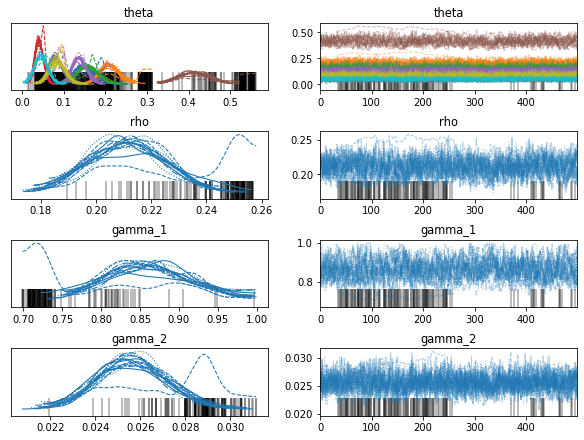

In [13]:
# Evaluate fit with test and trace resample
arviz.plot_trace(resample_fit, figsize=(8, 6));

In [14]:
# View results
print("Inference when trained with test and trace resampling:")
print(resample_fit)
print()
print('Ground truth:')
print('Setting specific transmission rates: ', true_transmission_rate)
print('Base rate: ', base_rate)
print('Prob(tested | infected): ', p)
print('Prob(tested | not-infected): ', q)

Inference when trained with test and trace resampling:
Inference for Stan model: tt_resampled_mod_6901789939ab50268554270350c516a5.
16 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=8000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]    0.15  1.1e-3   0.03    0.1   0.13   0.15   0.17    0.2    551   1.04
theta[2]    0.21  2.5e-3   0.03   0.17    0.2   0.21   0.23   0.28    110   1.16
theta[3]    0.16  6.4e-4   0.02   0.11   0.14   0.16   0.18   0.21   1521   1.01
theta[4]    0.04  2.3e-4   0.01   0.02   0.03   0.04   0.05   0.06   2095   1.02
theta[5]    0.14  2.0e-3   0.02   0.11   0.13   0.14   0.15   0.19    101   1.17
theta[6]    0.42  3.7e-3   0.04   0.35   0.39   0.42   0.44   0.52    127   1.14
theta[7]    0.08  3.8e-4   0.02   0.05   0.07   0.08    0.1   0.12   2436   1.01
theta[8]    0.08  6.8e-4   0.02   0.05   0.07   0.08   0.09   0.12    585   1.03
theta[9]    0.08  3.4e